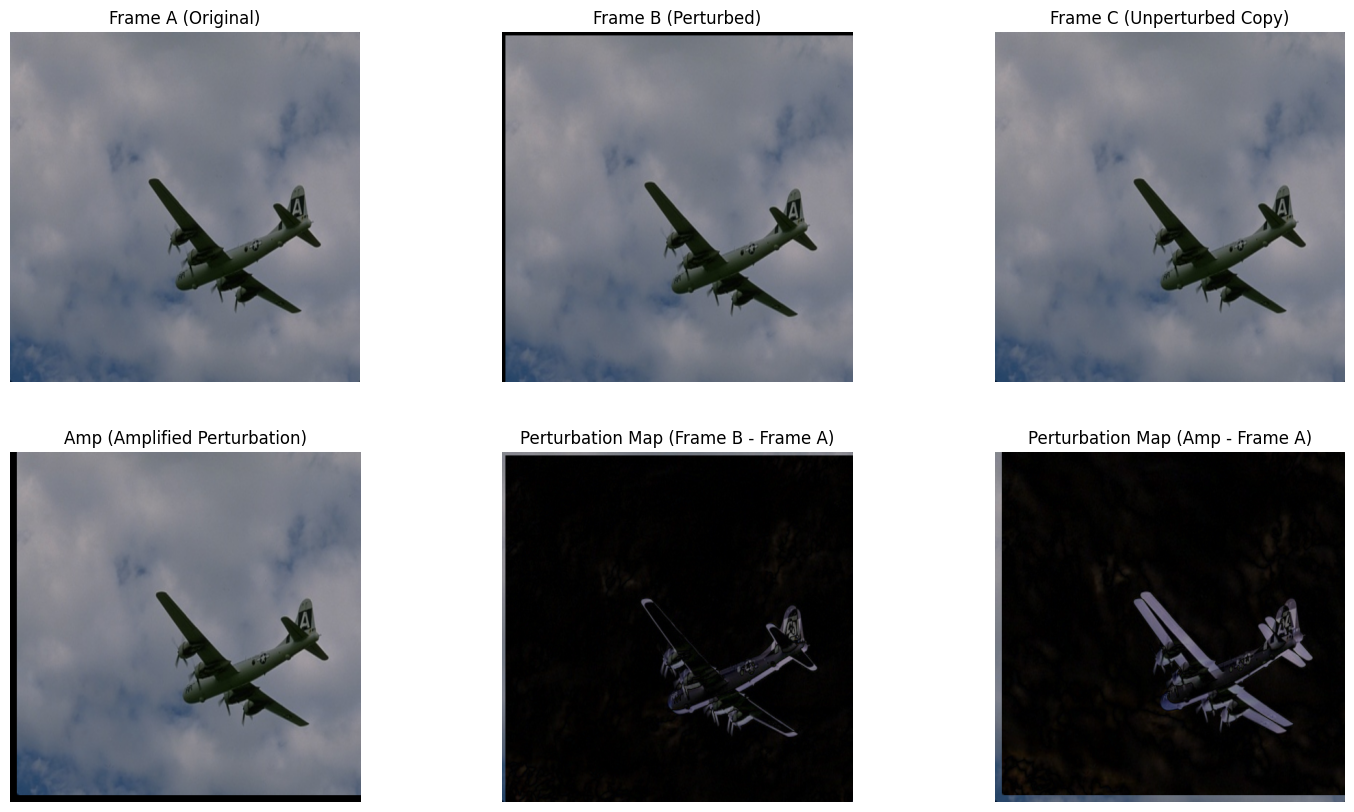

Segmented dataset with perturbations saved in: generated_dataset


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os

# Download a sample image from a public dataset (BSDS500)
image_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/images/test/3096.jpg"
image_path = "sample_image.jpg"
urllib.request.urlretrieve(image_url, image_path)

# Load image
image = cv2.imread(image_path)
image = cv2.resize(image, (512, 512))  # Resize for uniformity
mask = np.zeros(image.shape[:2], np.uint8)

# Define background and foreground models for GrabCut
bg_model = np.zeros((1, 65), np.float64)
fg_model = np.zeros((1, 65), np.float64)

# Define a rectangle around the object (manual tuning needed per dataset)
rect = (50, 50, 450, 450)

# Apply GrabCut segmentation
cv2.grabCut(image, mask, rect, bg_model, fg_model, 5, cv2.GC_INIT_WITH_RECT)

# Create foreground mask (1 = foreground, 0 = background)
fg_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Generate foreground and background
foreground = image * fg_mask[:, :, np.newaxis]
background = image * (1 - fg_mask[:, :, np.newaxis])

# Combine foreground and background (Frame A - Original)
frame_A = foreground + background

# Apply relative displacement for perturbation (Frame B)
M_shift = np.float32([[1, 0, 5], [0, 1, 5]])  # Small shift (5px right, 5px down)
frame_B = cv2.warpAffine(frame_A, M_shift, (frame_A.shape[1], frame_A.shape[0]))

# Generate Frame C (another unperturbed copy)
frame_C = frame_A.copy()

# Apply amplified perturbation (Frame Amp)
M_large_shift = np.float32([[1, 0, 10], [0, 1, -10]])  # Larger shift (10px right, 10px up)
amp = cv2.warpAffine(frame_A, M_large_shift, (frame_A.shape[1], frame_A.shape[0]))

# Compute perturbation visualization (optical flow approximation)
flow = cv2.absdiff(frame_B, frame_A)  # Difference visualization
flow_amp = cv2.absdiff(amp, frame_A)  # Amplified difference

# Save results
output_dir = "generated_dataset"
os.makedirs(output_dir, exist_ok=True)

cv2.imwrite(f"{output_dir}/frame_A.png", frame_A)
cv2.imwrite(f"{output_dir}/frame_B.png", frame_B)
cv2.imwrite(f"{output_dir}/frame_C.png", frame_C)
cv2.imwrite(f"{output_dir}/amp.png", amp)
cv2.imwrite(f"{output_dir}/perturbation_map_B.png", flow)
cv2.imwrite(f"{output_dir}/perturbation_map_amp.png", flow_amp)

# Display results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].imshow(cv2.cvtColor(frame_A, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Frame A (Original)")

axes[0, 1].imshow(cv2.cvtColor(frame_B, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("Frame B (Perturbed)")

axes[0, 2].imshow(cv2.cvtColor(frame_C, cv2.COLOR_BGR2RGB))
axes[0, 2].set_title("Frame C (Unperturbed Copy)")

axes[1, 0].imshow(cv2.cvtColor(amp, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Amp (Amplified Perturbation)")

axes[1, 1].imshow(cv2.cvtColor(flow, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title("Perturbation Map (Frame B - Frame A)")

axes[1, 2].imshow(cv2.cvtColor(flow_amp, cv2.COLOR_BGR2RGB))
axes[1, 2].set_title("Perturbation Map (Amp - Frame A)")

for ax in axes.ravel():
    ax.axis("off")

plt.show()

print(f"Segmented dataset with perturbations saved in: {output_dir}")